<a href="https://colab.research.google.com/github/nazmus007/arch1_shayan/blob/main/bert_meta_arch1_run2_shayan_ghosh_val_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -qq transformers

     |████████████████████████████████| 4.2 MB 7.9 MB/s 
     |████████████████████████████████| 86 kB 4.7 MB/s 
     |████████████████████████████████| 6.6 MB 65.3 MB/s 
     |████████████████████████████████| 596 kB 8.9 MB/s 


In [ ]:
print(transformers.__version__)

4.10.0


In [2]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 8.0 MB/s 
     |████████████████████████████████| 181 kB 74.2 MB/s 
     |████████████████████████████████| 145 kB 59.4 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=32879339533850579699b24d15392a405c9e50a27e5421dd9e265db79d795700
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [3]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import transformers

from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, BertForSequenceClassification

import torch
import re
import numpy as np
import pandas as pd

import seaborn as sns

from pylab import rcParams

import matplotlib.pyplot as plt

from matplotlib import rc

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report

from collections import defaultdict

from textwrap import wrap

from torch import nn, optim

from torch.utils.data import Dataset, DataLoader

In [6]:
import torch.nn.functional as F

In [7]:
df_train = pd.read_csv("./drive/MyDrive/datasets/5datasets_combined_arch1_train.csv")

In [8]:
df_val = pd.read_csv("./drive/MyDrive/datasets/cleaned_ghosh_dev_may22.csv")

In [9]:
df_test = pd.read_csv("./drive/MyDrive/datasets/cleaned_ghosh_test_may22.csv")

In [ ]:
df_train = df_train.sort_values(by= "Label")

In [ ]:
df_val = df_val.sort_values(by= "Label")

In [ ]:
df_test = df_test.sort_values(by= "Label")

In [ ]:
df_train = df_train[20000:102158]

In [ ]:
df_val = df_val[9000:21198]

In [ ]:
df_test= df_test[8000:] 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


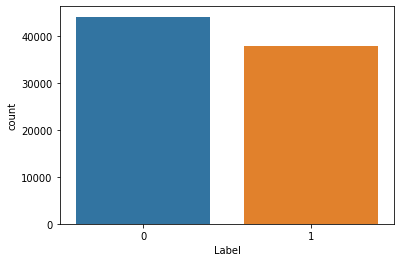

In [ ]:
import seaborn as sns
sns.countplot(df_val.Label)
plt.xlabel('Label');


In [ ]:
emoji_1 = re.compile('[\\u203C-\\u3299\\U0001F000-\\U0001F644]')

In [ ]:
emoji_list= list(filter(emoji_1.match, df_train['Tweet']))

In [ ]:
print(emoji_list)

['♥♥♥ rt  gif 131122 yixing heart to camera cr ', '【ml30】poland depth 10km nov 16 2013 121240 utc grin emsc', '♫ today prague czech republic  dec 31 at nye  cross club ', '♫ today prague czech republic  nov 18 at roxy ', '★ šok ★ hardwell priznal že ghostprodukoval 1 track z beatport top 10 ktorý to asi bude  s touto temnou ', '🎧my top 3 lastfm artists howard shore 14 dżem 8 andamp justin timberlake 7 ', '🌞gm☕️         followfriday', '♫ just downloaded new world sound andamp thomas newson  by     via ', '♫ today cottbus germany  nov 30 at blue moon festival ', '😂 rt   my uncle used to refer to missed calls as miskeen calls  laugh out loud', '🌞h ꭺꮲꮲꮍwꭼꭼꮶꭼꮑꭰ mꮍ fꮢꭵꭼꮑꭰs💕        ', '♥♥♥ rt  make sure to watch the special stage of exo 12월의기적miracles in december at kbs music bank ', '♫ mortal kombat theme  game theme – misterioustheme  nowplaying', '♫ just downloaded i am the melodyman hardcore edit by     via ', '😋 deli salat feldsalat jogurtsauce healty vegetarian whatvegetarianseat schnit

In [ ]:
emo_found= ' '.join(emoji for emoji in emoji_list)

In [ ]:
!pip install demoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 1.6 MB/s 


In [ ]:
import demoji
def demoji_text(text):
  d= demoji.findall(text)
  return d

In [ ]:
df_train['emoji_list'] = df_train['Tweet'].apply(demoji_text)

In [ ]:
f= list(filter(None, df_train['emoji_list']))

In [ ]:
print(f)

[{'😘': 'face blowing a kiss'}, {'😔': 'pensive face'}, {'☺': 'smiling face'}, {'😂': 'face with tears of joy'}, {'😿': 'crying cat', '😶': 'face without mouth'}, {'💕': 'two hearts'}, {'♥': 'heart suit'}, {'👌': 'OK hand'}, {'✋': 'raised hand'}, {'😍': 'smiling face with heart-eyes', '👌': 'OK hand'}, {'😩': 'weary face', '😭': 'loudly crying face'}, {'😉': 'winking face'}, {'❤️': 'red heart'}, {'💗': 'growing heart', '💕': 'two hearts'}, {'😂': 'face with tears of joy'}, {'♥': 'heart suit'}, {'👼': 'baby angel', '👙': 'bikini'}, {'🎶': 'musical notes'}, {'😊': 'smiling face with smiling eyes'}, {'🙊': 'speak-no-evil monkey', '😆': 'grinning squinting face', '🙈': 'see-no-evil monkey'}, {'😂': 'face with tears of joy'}, {'😒': 'unamused face', '✌️': 'victory hand'}, {'🐰': 'rabbit face', '🙊': 'speak-no-evil monkey', '💚': 'green heart'}, {'😘': 'face blowing a kiss'}, {'😳': 'flushed face'}, {'😉': 'winking face'}, {'👌': 'OK hand'}, {'😮': 'face with open mouth'}, {'☠': 'skull and crossbones'}, {'😀': 'grinning fac

In [ ]:
all_keys = set().union(*(d.keys() for d in f))

In [ ]:
print(all_keys)

{'✋', '👨\u200d👩\u200d👦\u200d👦', '🌚', '✊', '☺', '👰', '🔋', '😰', '😋', '🛒', '🚡', '💟', '💦', '⚡', '🐷', '🤐', '💙', '🤷\u200d♂️', '🔒', '🥩', '🙏🏼', '👬', '🇪🇸', '✒️', '🚽', '✊🏿', '🎅🏻', '💫', '👳', '😮', '👼', '®', '🌙', '📌', '🐺', '👗', '☣', '💰', '👨\u200d👩\u200d👧\u200d👧', '🆗', '♏', '💎', '🧘🏻\u200d♀️', '🐢', '🎇', '👇🏽', '🤧', '🤕', '🔕', '⏩', '🇫🇯', '🤦🏽\u200d♀️', '2️⃣', '👹', '🤩', '▪', '🙏🏿', '🍕', '🔓', '⬆', '⚪', '🍌', '🤘🏻', '📤', '🙋🏼\u200d♀️', '👯', '🌲', '📅', '🤚🏽', '⛈️', '🤭', '🌏', '☹️', '🏂', '😅', '🛀', '👐', '💁🏻\u200d♀️', '🌪', '🔷', '🤬', '🏋', '🔵', '😻', '🍳', '😺', '🚑', '🇧🇸', '☃', '⁉️', '👀', '👃', '🙏', '🙃', '☀', '🎣', '🤘', '💣', '💪🏼', '🤟🏽', '🍑', '🌾', '😶', '😷', '🐍', '🙌🏽', '👾', '😖', '🔌', '👸🏽', '🤫', '🐾', '🌧', '🍓', '🐸', '👱', '🤨', '🦀', '🏃\u200d♂️', '🤷\u200d♀️', '🍉', '➡️', '🍆', '🌱', '🌟', '🌵', '🗽', '✈️', '🕺', '🦅', '🔨', '🔮', '🐱', '🧛\u200d♂️', '🖖🏻', '🌞', '🎃', '⏱', '⭐', '💁', '🚷', '🎺', '💌', '♠️', '🎭', '🍹', '⛄', '🐐', '💅', '1️⃣', '🤙🏽', '💕', '📮', '🇸🇸', '☝️', '🌤', '🐙', '✔️', '🆓', '😨', '📸', '💁🏻\u200d♂️', '🎿', '✊🏾', '👌🏼', '🤦\u200d♂️', '❄', '🙏🏽',

In [ ]:
len(all_keys)

820

In [ ]:
all_keys = list(all_keys)

In [ ]:
from emoji import UNICODE_EMOJI

def get_emoji_set(text):
    return {letter for letter in text if letter in UNICODE_EMOJI['en'] }

In [ ]:
c = get_emoji_set(emo_found)

In [ ]:
print(c)

{'☁', '💦', '🎤', '🎅', '✨', '🏥', '😬', '😱', '❣', '😭', '😴', '🌍', '😅', '👏', '☕', '😁', '🕺', '🏿', '🤦', '😔', '💜', '📂', '✌', '❤', '🏾', '🖖', '😓', '💎', '🎂', '💯', '🌺', '💆', '🌹', '🐠', '😋', '🤪', '🍣', '😣', '😚', '♀', '👉', '📁', '💚', '✊', '😯', '▶', '👌', '😊', '😢', '💇', '📊', '🙁', '😂', '😖', '🐒', '💔', '😎', '🍻', '😃', '🔫', '🍕', '😥', '💣', '💙', '✔', '🐈', '🌏', '🔥', '💥', '🍊', '✝', '🔊', '💗', '📹', '🗽', '🎧', '🎶', '🌰', '🙍', '💈', '😑', '😞', '👦', '🏼', '💩', '🐸', '👊', '🍋', '😜', '😳', '😩', '💕', '🎵', '♊', '😛', '💀', '💃', '🍟', '😏', '😝', '⛽', '🎭', '🌸', '👫', '🤷', '🏽', '🌶', '🍀', '🏃', '⬛', '💪', '🎄', '😘', '🙀', '🔴', '🌟', '😲', '😈', '👆', '😍', '⚽', '🎈', '🎥', '⚠', '🍎', '🌄', '🍾', '💁', '😄', '🍁', '💖', '🎬', '👋', '🐚', '💊', '🌞', '🎪', '☮', '🌚', '💓', '😮', '❕', '👇', '🙄', '😨', '🕸', '👍', '✋', '😕', '😇', '😌', '🔪', '☀', '☃', '😼', '☠', '🍩', '👈', '⏳', '👼', '🏈', '📱', '🐥', '🅰', '😆', '😫', '🚫', '💐', '😡', '😉', '😀', '😒', '🎁', '🙏', '🍷', '🐾', '⭐', '♂', '🚽', '🐰', '🎼', '🔱', '🍃', '🎎', '🍔', '👑', '🤣', '❄', '☺', '🙌', '🌙', '🤨', '🏻', '🐱', '💋', '🐶', '👸', '👀', '🏆', '⁉',

In [ ]:
len(c)

218

In [10]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

In [11]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
tokenizer.add_tokens(['✋', '👨\u200d👩\u200d👦\u200d👦', '🌚', '✊', '☺', '👰', '🔋', '😰', '😋', '🛒', '🚡', '💟', '💦', '⚡', '🐷', '🤐', '💙', '🤷\u200d♂️', '🔒', '🥩', '🙏🏼', '👬', '🇪🇸', '✒️', '🚽', '✊🏿', '🎅🏻', '💫', '👳', '😮', '👼', '®', '🌙', '📌', '🐺', '👗', '☣', '💰', '👨\u200d👩\u200d👧\u200d👧', '🆗', '♏', '💎', '🧘🏻\u200d♀️', '🐢', '🎇', '👇🏽', '🤧', '🤕', '🔕', '⏩', '🇫🇯', '🤦🏽\u200d♀️', '2️⃣', '👹', '🤩', '▪', '🙏🏿', '🍕', '🔓', '⬆', '⚪', '🍌', '🤘🏻', '📤', '🙋🏼\u200d♀️', '👯', '🌲', '📅', '🤚🏽', '⛈️', '🤭', '🌏', '☹️', '🏂', '😅', '🛀', '👐', '💁🏻\u200d♀️', '🌪', '🔷', '🤬', '🏋', '🔵', '😻', '🍳', '😺', '🚑', '🇧🇸', '☃', '⁉️', '👀', '👃', '🙏', '🙃', '☀', '🎣', '🤘', '💣', '💪🏼', '🤟🏽', '🍑', '🌾', '😶', '😷', '🐍', '🙌🏽', '👾', '😖', '🔌', '👸🏽', '🤫', '🐾', '🌧', '🍓', '🐸', '👱', '🤨', '🦀', '🏃\u200d♂️', '🤷\u200d♀️', '🍉', '➡️', '🍆', '🌱', '🌟', '🌵', '🗽', '✈️', '🕺', '🦅', '🔨', '🔮', '🐱', '🧛\u200d♂️', '🖖🏻', '🌞', '🎃', '⏱', '⭐', '💁', '🚷', '🎺', '💌', '♠️', '🎭', '🍹', '⛄', '🐐', '💅', '1️⃣', '🤙🏽', '💕', '📮', '🇸🇸', '☝️', '🌤', '🐙', '✔️', '🆓', '😨', '📸', '💁🏻\u200d♂️', '🎿', '✊🏾', '👌🏼', '🤦\u200d♂️', '❄', '🙏🏽', '🥵', '🐬', '🐑', '🔻', '📺', '🍛', '🍩', '🥪', '😚', '💐', '💆🏻\u200d♂', '🌳', '☺️', '👴', '😜', '🤦🏼\u200d♂️', '🚪', '🥓', '🕑', '⬆️', '⚫', '‼️', '🏵', '🌸', '👌🏿', '🤦🏽\u200d♂️', '💁\u200d♂️', '🤦🏼\u200d♀️', '🎑', '🕥', '💍', '✌🏽', '🚫', '😡', '🌶', '🍟', '💴', '🌊', '💆🏼\u200d♂️', '😁', '🌻', '🗣', '📊', '🚲', '🔜', '🌁', '🙅\u200d♂️', '📱', '⛸', '👏🏾', '👲', '🚴\u200d♂️', '🎉', '⛅', '🙅🏽\u200d♂️', '👏🏿', '🐨', '🎤', '🍂', '👆', '🏃', '🙉', '🅰', '🤦\u200d♀️', '☑', '🔚', '⛈', '🏎', '⛽', '👍🏼', '🍴', '💃', '⚖️', '😦', '🎸', '🔞', '😇', '😐', '🏰', '🌥', '🐏', '🙅🏾\u200d♂️', '💔', '🏏', '🐧', '📄', '👒', '👉🏽', '✏️', '🙆', '🍏', '🦂', '☠️', '™', '🌃', '😳', '🔰', '🎪', '🌝', '👉', '🐘', '👦🏻', '🙋🏻\u200d♀️', '😹', '🇦🇷', '👊🏼', '🏀', '🍅', '©', '😄', '✌️', '☠', '🆘', '🏄\u200d♂️', '🖕🏼', '🏆', '👧', '✈', '⏳', '🍰', '🍁', '🔊', '🐣', '☮', '👆🏽', '👈', '✂️', '🇬🇧', '🏜', '👏', '🍯', '🎥', '⤵', '😫', '💄', '🐀', '💡', '😏', '🗡️', '✊🏻', '🖕🏽', '❤', '💁🏼', '🌴', '👓', '💛', '🤷🏻\u200d♀️', '💊', '💈', '👽', '🌈', '🇮🇹', '😗', '❕', '🚶', '💪🏻', '📚', '🎵', '🚺', '✏', '🌄', '🙀', '🤔', '💞', '👫', '🚛', '🙌', '🍊', '🐔', '👨', '✝️', '🎬', '😆', '🤟🏻', '🍈', '🦋', '🚗', '📞', '👩🏼\u200d⚕️', '✌', '🥰', '🧟\u200d♂️', '💧', '🍵', '🌎', '🤡', '📹', '💨', '🚓', '🚴', '🥅', '😑', '🎷', '👂', '👠', '🤷🏾', '🗿', '😭', '🚊', '👼🏿', '☔', '🍬', '♐', '✋🏼', '💵', '🏥', '🤪', '☄', '🤷🏾\u200d♂️', '👮', '🎂', '🖐', '🎄', '🏊', '🐻', '☁', '🔔', '🍼', '😾', '👉🏿', '⚜️', '🐼', '🐚', '🇯🇵', '💥', '😧', '✴', '😊', '🙇', '🌯', '👌🏽', '❗', '🍎', '♿', '🥳', '🛏', '🤷🏼\u200d♀️', '📣', '😈', '🐽', '🌆', '🚨', '🍃', '🐶', '🤞', '💁🏽', '👊🏻', '🎨', '⛪', '🐛', '🚮', '✝', '😌', '🧐', '🧘🏽\u200d♀️', '🗑', '💏', '👦', '👚', '🕸', '🔦', '💜', '🌂', '🍇', '🌿', '🏒', '💶', '🍄', '💀', '🎈', '🐈', '🐮', '🐟', '💪', '📨', '👇🏼', '👍', '🛰', '🤷🏽\u200d♀️', '😛', '🏃🏼\u200d♀️', '👨\u200d👩\u200d👧\u200d👦', '💩', '🤗', '🌍', '🐉', '🤓', '⬇️', '☀️', '👈🏽', '😩', '💳', '🔄', '🎙️', '🍜', '👏🏼', '🕹️', '↩️', '☮️', '🍨', '🏴\U000e0067\U000e0062\U000e0065\U000e006e\U000e0067\U000e007f', '⚠', '😎', '⬇', '☕', '🐗', '👦🏿', '🤠', '🤙', '🍭', '😝', '👩', '🌬', '⚽', '👍🏻', '⬛', '🙌🏾', '♈', '🤢', '📖', '🔐', '🚍', '👼🏻', '💤', '📉', '🐂', '🎌', '🇺🇸', '🐳', '🖖🏽', '👄', '🍺', '❣', '⏲', '👌', '👏🏽', '📯', '🍖', '🤥', '😴', '🎅', '🐰', '🏽', '🍔', '🔬', '👟', '💚', '🤙🏻', '🚌', '🤦🏻\u200d♀️', '🖕', '📜', '👅', '📓', '😲', '📵', '🖤', '✨', '🔪', '👙', '😣', '🧠', '🏡', '🐜', '😒', '📥', '👻', '🙆\u200d♂️', '☹', '⚠️', '😤', '🇩🇪', '👿', '👋🏻', '🇪🇨', '👵', '💽', '🇪🇺', '🎯', '♥', '➖', '🎙', '🏦', '💉', '🐵', '🍝', '🍚', '📀', '🌨', '👍🏽', '👏🏻', '🏃\u200d♀️', '🐫', '👮\u200d♂️', '🏈', '♊', '😢', '🕷', '🍫', '📂', '▶', '💁🏽\u200d♀️', '✂', '🐴', '🔱', '😟', '💲', '📃', '💯', '🕰', '👸🏼', '🐅', '🎹', '🙋\u200d♀️', '🍀', '👆🏼', '🙊', '👣', '❄️', '🙁', '👉🏻', '🐯', '📆', '♥️', '😀', '💾', '🚼', '🐄', '🖖', '🅿️', '👔', '💖', '👨🏾\u200d💻', '🆙', '😠', '🌰', '🌅', '🛌', '💻', '🍒', '🙆🏻', '♉', '🐠', '👨🏻\u200d💻', '📶', '🇫🇷', '💅🏾', '🧡', '🙋', '💁🏼\u200d♂️', '📻', '😘', '🚂', '🔑', '🛋', '💷', '✅', '🛎', '🤑', '🦃', '👪', '🏹', '⭕', '💗', '👑', '🙌🏻', '👭', '⏰', '🏿', '🎎', '🥜', '🍋', '🐕', '⛵', '👌🏾', '⚰️', '💘', '◀️', '🙅', '😿', '🤷🏼\u200d♂️', '🤙🏼', '💁\u200d♀️', '🐇', '🦌', '🚙', '✍', '🎓', '🥬', '🔥', '🚐', '🔗', '🍗', '🌽', '😼', '🥃', '🐒', '🐊', '🚀', '✌🏾', '🎧', '🗯', '😥', '🏐', '💓', '🆕', '🤯', '⛷', '👍🏿', '👊', '🏇', '🇧🇪', '🌠', '😽', '🚔', '🏃🏽', '💆🏻\u200d♂️', '🐥', '👎🏻', '🎶', '📝', '😬', '🎼', '🙍', '📍', '🎆', '👼🏽', '👋', '😃', '💇🏾\u200d♀️', '🙎', '🍿', '👎', '👇🏻', '👇', '💪🏽', '🐁', '❎', '👌🏻', '🦄', '📈', '🎁', '☁️', '😸', '☝🏽', '😞', '🙋🏻\u200d♂️', '🙂', '😪', '❓', '⏺️', '🌼', '🖼', '🇮🇳', '♦', '💢', '😔', '🌀', '❤️', '🍥', '🚎', '🍦', '🚣', '👶', '📷', '😱', '💭', '🍣', '🌋', '😯', '🤷🏿\u200d♀️', '💸', '🖊', '🐿', '🍪', '⚾', '✌🏼', '➰', '🍍', '☝', '🙅🏻', '🔫', '🎻', '🙌🏼', '👍🏾', '💁🏻\u200d♂', '🤤', '⚓', '✌🏻', '⁉', '🈵', '🔉', '🍡', '🕐', '💋', '😵', '😕', '👸🏻', '🤦🏽', '🌺', '👎🏼', '🚜', '🍧', '⚒️', '❌', '🤦🏻\u200d♂️', '🙄', '🆒', '🥇', '🥂', '🍻', '🎊', '🏢', '0⃣', '3️⃣', '🔴', '🤣', '🔝', '🌌', '✔', '🚘', '🍤', '📁', '😂', '🍸', '🎀', '💝', '🤮', '🎮', '🏁', '🌮', '✖', '🤦', '🚢', '🌹', '😙', '👸', '😍', '🇩🇰', '👴🏻', '😓', '🤟🏾', '☂', '😉', '🍷', '💑', '🍾', '➡', '🚬', '👺', '🇨🇦', '🙈'])

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

814

In [12]:
df_train_X= list(df_train["Tweet"])
df_val_X = list(df_val["Tweet"])

In [13]:
y_train = list(df_train["Label"])

y_val = list(df_val["Label"])

y_test = list(df_test["Label"])

In [14]:
X_train_tokenized = tokenizer(df_train_X, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(df_val_X, padding=True, truncation=True, max_length=512)

In [15]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [16]:
train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)


In [17]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

model.resize_token_embeddings(len(tokenizer))

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Embedding(31336, 768)

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [19]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31336, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [20]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [21]:
output_dir='./drive/MyDrive/savedmodel_meta/arch1_final_shayan_ghosh'

In [22]:
import wandb 

In [23]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="steps",
    weight_decay = 0.01,
    logging_steps = 500,
    eval_steps = 500,
    logging_dir='./logs/arch1_run3_ghosh',
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    seed=123,
    load_best_model_at_end=True,
    #save_total_limit=1,
    learning_rate = 2e-5
)

In [24]:
from transformers import EarlyStoppingCallback

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args= args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,             # evaluation dataset
    tokenizer = tokenizer,
    compute_metrics = compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=20)]
)

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 102157
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51080
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Currently logged in as: nazmus007. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
500,0.611700,0.746248,0.513376,0.056462,0.789474,0.105386
1000,0.529700,0.682480,0.637580,0.074751,0.789474,0.136571
1500,0.504700,0.856920,0.542675,0.070221,0.947368,0.130751
2000,0.478600,0.592061,0.756051,0.110048,0.807018,0.193684
2500,0.461200,0.613284,0.715287,0.097107,0.824561,0.173752
3000,0.460200,0.451837,0.829299,0.134948,0.684211,0.225434
3500,0.459100,0.534853,0.721656,0.099156,0.824561,0.177024
4000,0.437400,0.596559,0.696178,0.097701,0.894737,0.176166
4500,0.438100,0.734594,0.619745,0.076803,0.859649,0.141007
5000,0.427300,0.540246,0.738854,0.103371,0.807018,0.183267


***** Running Evaluation *****
  Num examples = 1570
  Batch size = 8
Saving model checkpoint to ./drive/MyDrive/savedmodel_meta/arch1_final_shayan_ghosh/checkpoint-500
Configuration saved in ./drive/MyDrive/savedmodel_meta/arch1_final_shayan_ghosh/checkpoint-500/config.json
Model weights saved in ./drive/MyDrive/savedmodel_meta/arch1_final_shayan_ghosh/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./drive/MyDrive/savedmodel_meta/arch1_final_shayan_ghosh/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./drive/MyDrive/savedmodel_meta/arch1_final_shayan_ghosh/checkpoint-500/special_tokens_map.json
added tokens file saved in ./drive/MyDrive/savedmodel_meta/arch1_final_shayan_ghosh/checkpoint-500/added_tokens.json
***** Running Evaluation *****
  Num examples = 1570
  Batch size = 8
Saving model checkpoint to ./drive/MyDrive/savedmodel_meta/arch1_final_shayan_ghosh/checkpoint-1000
Configuration saved in ./drive/MyDrive/savedmodel_meta/arch1_final_shayan_

TrainOutput(global_step=13000, training_loss=0.4339074225792518, metrics={'train_runtime': 4833.458, 'train_samples_per_second': 84.542, 'train_steps_per_second': 10.568, 'total_flos': 1.720861104807852e+16, 'train_loss': 0.4339074225792518, 'epoch': 1.02})

In [25]:
#test_data = pd.read_csv("test.csv")
X_test = list(df_test["Tweet"])
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

# Create torch dataset
test_dataset = Dataset(X_test_tokenized,y_test)

# Load trained model
model_path = "./drive/MyDrive/savedmodel_meta/arch1_final_shayan_ghosh/checkpoint-3000"

model = BertForSequenceClassification.from_pretrained(model_path, num_labels=2)

# Define test trainer
test_trainer = Trainer(model)

# Make prediction
raw_pred, _, _ = test_trainer.predict(test_dataset)

# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)

loading configuration file ./drive/MyDrive/savedmodel_meta/arch1_final_shayan_ghosh/checkpoint-3000/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31336
}

loading weights file ./drive/MyDrive/savedmodel_meta/arch1_final_shayan_ghosh/checkpoint-3000/pytorch_model.bin
All model checkpoint wei

In [26]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, y_pred,labels=[1,0]))

              precision    recall  f1-score   support

           1       0.92      0.82      0.86       999
           0       0.83      0.92      0.88       975

    accuracy                           0.87      1974
   macro avg       0.87      0.87      0.87      1974
weighted avg       0.87      0.87      0.87      1974



In [27]:
class_names = [1,0]

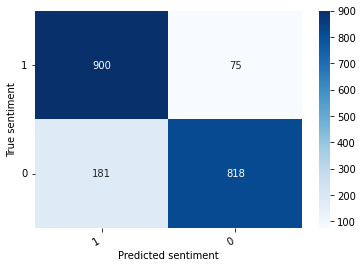

In [28]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)